# Project 2: Ames Housing Prices

## Problem Statement

Create a Linear Regression model to accurately predict house prices, given housing [data](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

Select 25-30 features out of 80, and refine model using cross validation and regularization.

Linear Regression model will be tested against unseen test data on [Kaggle](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/overview) based on Root Mean Squared Error between predicted and actual sale prices.

## Methodology

1. Clean and explore data to select first set of features for modelling
2. Split original training data into sub train/test sets
3. Create Linear Regression model using first feature set
4. Refine Linear Regression model using Ridge, Lasso and Elastic Net regression
5. Score Linear Regression using cross validation and prediction of (sub) test dataset
6. Analyse results of regression models to fine-tune feature engineering and create new feature sets
7. Repeat steps 3-6 on subsequent feature sets 
8. Select best performer for submission

## Data Cleaning and Exploratory Data Analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Read 'train' dataset and let the index be 'Id'
df = pd.read_csv('datasets/train.csv', index_col = 'Id')

In [3]:
df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PID              2051 non-null   int64  
 1   MS SubClass      2051 non-null   int64  
 2   MS Zoning        2051 non-null   object 
 3   Lot Frontage     1721 non-null   float64
 4   Lot Area         2051 non-null   int64  
 5   Street           2051 non-null   object 
 6   Alley            140 non-null    object 
 7   Lot Shape        2051 non-null   object 
 8   Land Contour     2051 non-null   object 
 9   Utilities        2051 non-null   object 
 10  Lot Config       2051 non-null   object 
 11  Land Slope       2051 non-null   object 
 12  Neighborhood     2051 non-null   object 
 13  Condition 1      2051 non-null   object 
 14  Condition 2      2051 non-null   object 
 15  Bldg Type        2051 non-null   object 
 16  House Style      2051 non-null   object 
 17  Overall Qual  

The data consists of 2051 rows and 81 columns, of which the SalePrice column is the target of our prediction, and the other 80 columns are the features to select and build the model on. As the number of columns/features is large, we can group the features by their type based on information in the data dictionary.

In [5]:
# As the number of features is large, review data dictionary to group features by type
feature_groups = {

# Do not include 'PID' into Nominal features
    'Nominal':    ['MS SubClass',
                   'MS Zoning',
                   'Street',
                   'Alley',
                   'Land Contour',
                   'Lot Config',
                   'Neighborhood',
                   'Condition 1',
                   'Condition 2',
                   'Bldg Type',
                   'House Style',
                   'Roof Style',
                   'Roof Matl',
                   'Exterior 1st',
                   'Exterior 2nd',
                   'Mas Vnr Type',
                   'Foundation',
                   'Heating',
                   'Central Air',
                   'Garage Type',
                   'Misc Feature',
                   'Sale Type',],
    
    'Ordinal':    ['Lot Shape',
                   'Utilities',
                   'Land Slope',
                   'Overall Qual',
                   'Overall Cond',
                   'Exter Qual',
                   'Exter Cond',
                   'Bsmt Qual',
                   'Bsmt Cond',
                   'Bsmt Exposure',
                   'BsmtFin Type 1',
                   'BsmtFin Type 2',
                   'Heating QC',
                   'Electrical',
                   'Kitchen Qual',
                   'Functional',
                   'Fireplace Qu',
                   'Garage Finish',
                   'Garage Qual',
                   'Garage Cond',
                   'Paved Drive',
                   'Pool QC',
                   'Fence',],
    
    'Discrete':    ['Year Built',
                    'Year Remod/Add',
                    'Bsmt Full Bath',
                    'Bsmt Half Bath',
                    'Full Bath',
                    'Half Bath',
                    'Bedroom AbvGr',
                    'Kitchen AbvGr',
                    'TotRms AbvGrd',
                    'Fireplaces',
                    'Garage Yr Blt',
                    'Garage Cars',
                    'Mo Sold',
                    'Yr Sold'],
    
    'Continuous':  ['Lot Frontage',
                    'Lot Area',
                    'Mas Vnr Area',
                    'BsmtFin SF 1',
                    'BsmtFin SF 2',
                    'Bsmt Unf SF',
                    'Total Bsmt SF',
                    '1st Flr SF',
                    '2nd Flr SF',
                    'Low Qual Fin SF',
                    'Gr Liv Area',
                    'Garage Area',
                    'Wood Deck SF',
                    'Open Porch SF',
                    'Enclosed Porch',
                    '3Ssn Porch',
                    'Screen Porch',
                    'Pool Area',
                    'Misc Val',
                    'SalePrice'] 
}

### Nominal Features

In [6]:
df[feature_groups['Nominal']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MS SubClass   2051 non-null   int64 
 1   MS Zoning     2051 non-null   object
 2   Street        2051 non-null   object
 3   Alley         140 non-null    object
 4   Land Contour  2051 non-null   object
 5   Lot Config    2051 non-null   object
 6   Neighborhood  2051 non-null   object
 7   Condition 1   2051 non-null   object
 8   Condition 2   2051 non-null   object
 9   Bldg Type     2051 non-null   object
 10  House Style   2051 non-null   object
 11  Roof Style    2051 non-null   object
 12  Roof Matl     2051 non-null   object
 13  Exterior 1st  2051 non-null   object
 14  Exterior 2nd  2051 non-null   object
 15  Mas Vnr Type  2029 non-null   object
 16  Foundation    2051 non-null   object
 17  Heating       2051 non-null   object
 18  Central Air   2051 non-null   object
 19  Garage

#### Null values

There are null values for 'Alley', 'Mas Vnr Type', 'Garage Type' and 'Misc Feature'.

Per the data dictionary, null values reflect no alley, no masonry veneer, no garage and no miscellaneous feature respectively.

Null values for Nominal features can be filled with 'NA' or 'None' strings to reflect these categories.

In [7]:
# Fill null values for Nominal features with 'NA' or 'None', depending on the data dictionary
nominal_null_values = {'Alley': 'NA',
                       'Mas Vnr Type': 'None',
                       'Garage Type': 'NA',
                       'Misc Feature': 'NA'}
df.fillna(value=nominal_null_values, inplace=True)

#### Feature selection

In [8]:
# Explore overview of Nominal features' distributions using value_counts()
for feature in feature_groups['Nominal']:
    print(df[feature].value_counts(normalize=True))

20     0.375427
60     0.192101
50     0.096538
120    0.064359
30     0.049244
70     0.043881
160    0.042906
80     0.041931
90     0.036568
190    0.022428
85     0.013652
75     0.007801
45     0.005363
180    0.005363
40     0.001950
150    0.000488
Name: MS SubClass, dtype: float64
RL         0.779132
RM         0.154071
FV         0.049244
C (all)    0.009264
RH         0.006826
A (agr)    0.000975
I (all)    0.000488
Name: MS Zoning, dtype: float64
Pave    0.996587
Grvl    0.003413
Name: Street, dtype: float64
NA      0.931741
Grvl    0.041443
Pave    0.026816
Name: Alley, dtype: float64
Lvl    0.898586
HLS    0.041443
Bnk    0.039005
Low    0.020965
Name: Land Contour, dtype: float64
Inside     0.732813
Corner     0.169673
CulDSac    0.063871
FR2        0.029254
FR3        0.004388
Name: Lot Config, dtype: float64
NAmes      0.151146
CollgCr    0.087762
OldTown    0.079473
Edwards    0.069722
Somerst    0.063384
NridgHt    0.059483
Gilbert    0.056558
Sawyer     0.054120
Sawy

Some features have values with >90% frequency (e.g. 'Misc Feature' has 96.8% with 'NA'). These will not be useful to the Linear Regression model as they do not vary much.

In [9]:
# Drop features with frequency above a set threshold, as they will not be useful to the model
threshold = 0.9
drop_nominal = []

for feature in feature_groups['Nominal']:
    if max(list(df[feature].value_counts(normalize=True))) > threshold:
        drop_nominal.append(feature)

print(drop_nominal)

['Street', 'Alley', 'Condition 2', 'Roof Matl', 'Heating', 'Central Air', 'Misc Feature']


In [10]:
# Remove the above features from feature_groups
for feature in drop_nominal:
    feature_groups['Nominal'].remove(feature)

print(feature_groups['Nominal'])

['MS SubClass', 'MS Zoning', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Garage Type', 'Sale Type']


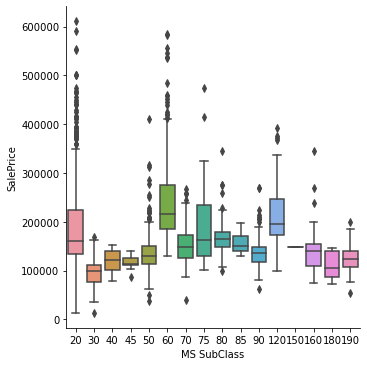

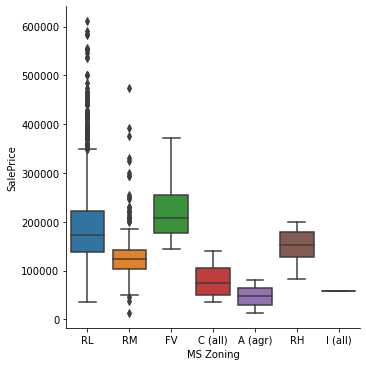

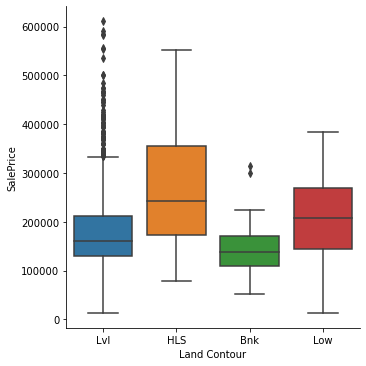

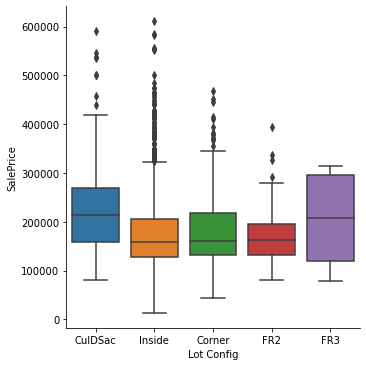

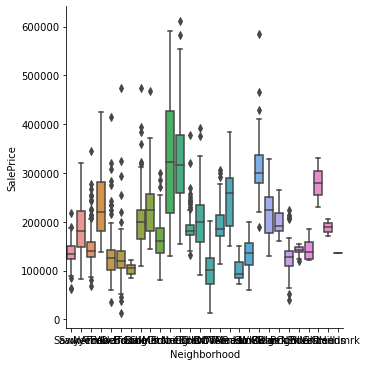

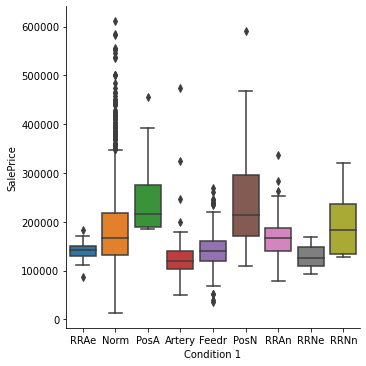

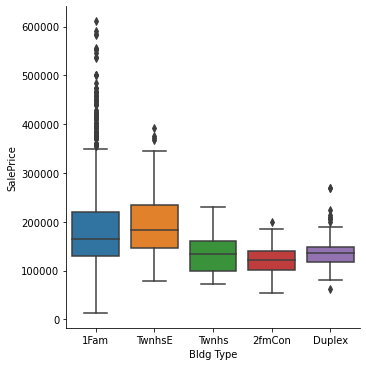

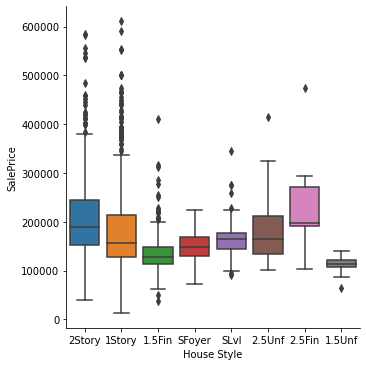

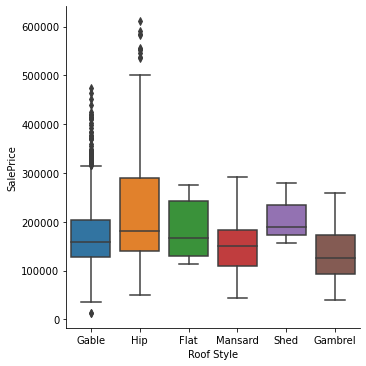

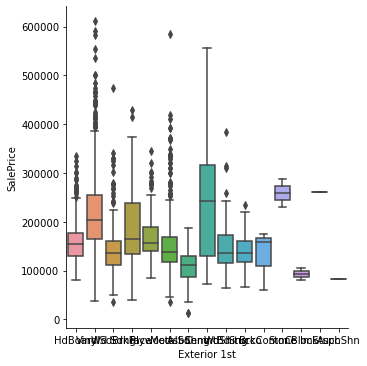

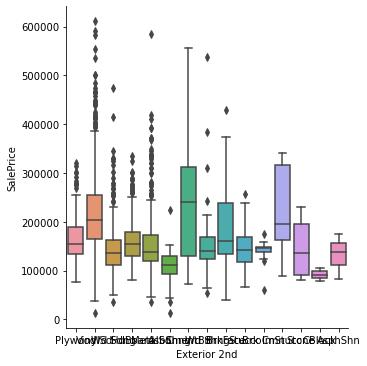

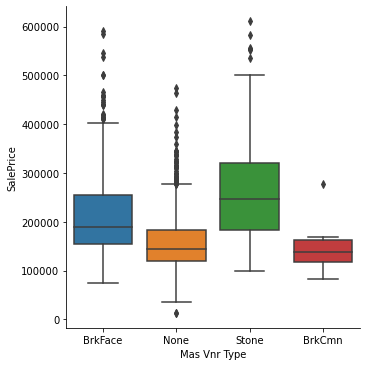

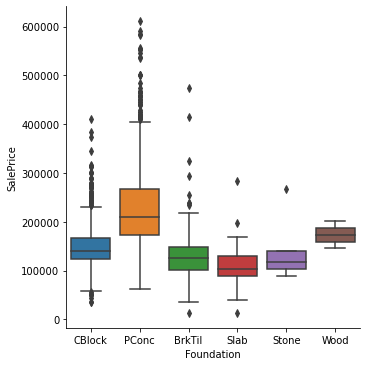

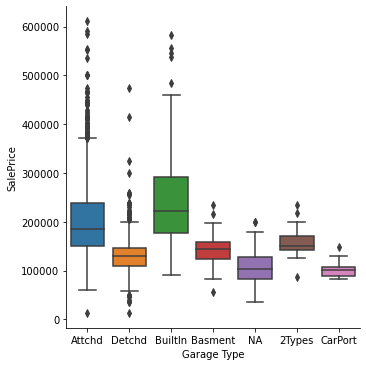

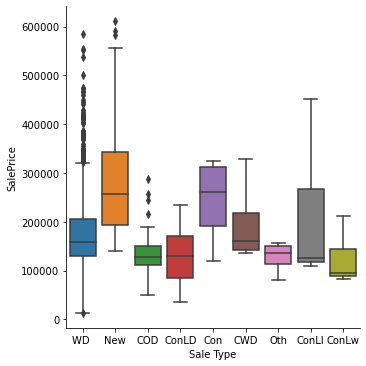

In [11]:
# Plot distributions of Nominal variables with SalePrice to estimate if any relationships exist
for feature in feature_groups['Nominal']:
    sns.catplot(x=feature, y='SalePrice', data=df, kind='box')

From the above, it does seem that SalePrice does vary with each remaining Nominal feature. We can binarize them for our first Linear Regression model and use Lasso regularization to eliminate irrelevant features.

In [12]:
# Nominal features to be retained in first feature set:
print(feature_groups['Nominal'])

['MS SubClass', 'MS Zoning', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Garage Type', 'Sale Type']


### Ordinal Features

In [13]:
df[feature_groups['Ordinal']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Lot Shape       2051 non-null   object
 1   Utilities       2051 non-null   object
 2   Land Slope      2051 non-null   object
 3   Overall Qual    2051 non-null   int64 
 4   Overall Cond    2051 non-null   int64 
 5   Exter Qual      2051 non-null   object
 6   Exter Cond      2051 non-null   object
 7   Bsmt Qual       1996 non-null   object
 8   Bsmt Cond       1996 non-null   object
 9   Bsmt Exposure   1993 non-null   object
 10  BsmtFin Type 1  1996 non-null   object
 11  BsmtFin Type 2  1995 non-null   object
 12  Heating QC      2051 non-null   object
 13  Electrical      2051 non-null   object
 14  Kitchen Qual    2051 non-null   object
 15  Functional      2051 non-null   object
 16  Fireplace Qu    1051 non-null   object
 17  Garage Finish   1937 non-null   object
 18  Garage Q

#### Null values

There are null values for 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC' and 'Fence'.

Per the data dictionary, null values reflect no alley, no masonry veneer, no garage and no miscellaneous feature respectively.

Null values for Ordinal features can be filled with 'NA' strings.

In [14]:
# Fill null values for Ordinal features with 'NA'
ordinal_null_values = {'Bsmt Qual': 'NA',
                       'Bsmt Cond': 'NA',
                       'Bsmt Exposure': 'NA',
                       'BsmtFin Type 1': 'NA',
                       'BsmtFin Type 2': 'NA',
                       'Fireplace Qu': 'NA',
                       'Garage Finish': 'NA',
                       'Garage Qual': 'NA',
                       'Garage Cond': 'NA',
                       'Pool QC': 'NA',
                       'Fence': 'NA'}
df.fillna(value=ordinal_null_values, inplace=True)

#### Feature selection

In [15]:
# Explore overview of Ordinal features' distributions using value_counts()
for feature in feature_groups['Ordinal']:
    print(df[feature].value_counts(normalize=True))

Reg    0.631399
IR1    0.337396
IR2    0.026816
IR3    0.004388
Name: Lot Shape, dtype: float64
AllPub    0.999025
NoSewr    0.000488
NoSeWa    0.000488
Name: Utilities, dtype: float64
Gtl    0.952218
Mod    0.042906
Sev    0.004876
Name: Land Slope, dtype: float64
5     0.274500
6     0.246709
7     0.210141
8     0.121892
4     0.077523
9     0.037543
3     0.014139
10    0.011214
2     0.004388
1     0.001950
Name: Overall Qual, dtype: float64
5    0.569478
6    0.179425
7    0.131643
8    0.049244
4    0.034130
3    0.017065
9    0.014139
2    0.002925
1    0.001950
Name: Overall Cond, dtype: float64
TA    0.607996
Gd    0.339834
Ex    0.039493
Fa    0.012677
Name: Exter Qual, dtype: float64
TA    0.866894
Gd    0.104827
Fa    0.023891
Ex    0.003413
Po    0.000975
Name: Exter Cond, dtype: float64
TA    0.432472
Gd    0.421258
Ex    0.089712
Fa    0.029254
NA    0.026816
Po    0.000488
Name: Bsmt Qual, dtype: float64
TA    0.894198
Gd    0.043393
Fa    0.031692
NA    0.026816
Po   

In [16]:
# Drop features with frequency above a set threshold, as they will not be useful to the model
threshold = 0.9
drop_ordinal = []

for feature in feature_groups['Ordinal']:
    if max(list(df[feature].value_counts(normalize=True))) > threshold:
        drop_ordinal.append(feature)

print(drop_ordinal)

['Utilities', 'Land Slope', 'Electrical', 'Functional', 'Garage Cond', 'Paved Drive', 'Pool QC']


In [17]:
# Remove the above features from feature_groups
for feature in drop_ordinal:
    feature_groups['Ordinal'].remove(feature)

print(feature_groups['Ordinal'])

['Lot Shape', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Fence']


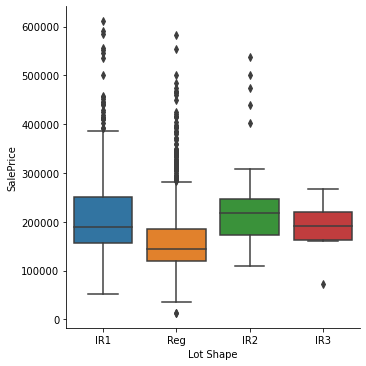

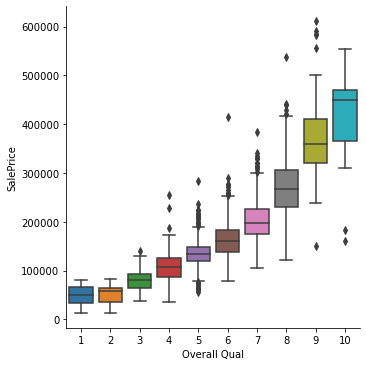

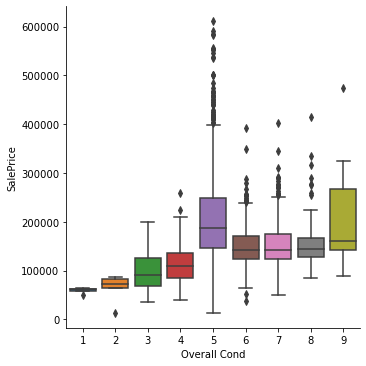

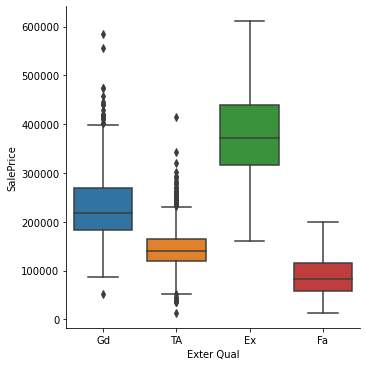

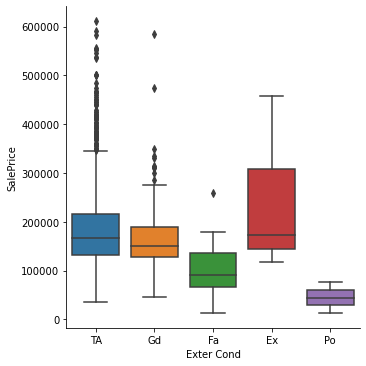

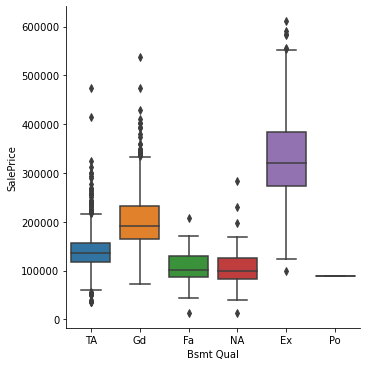

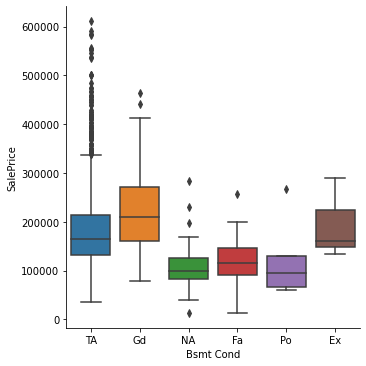

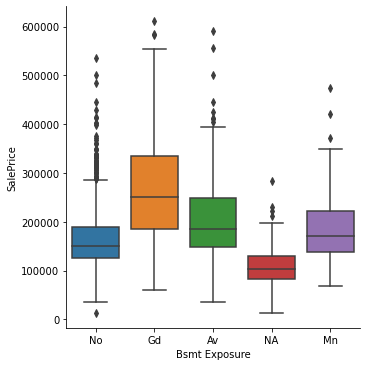

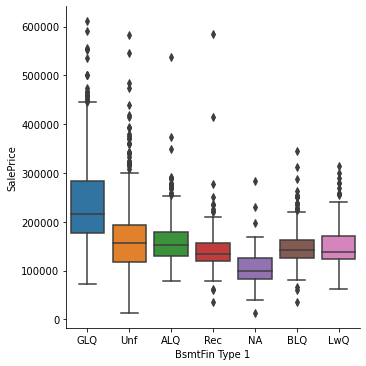

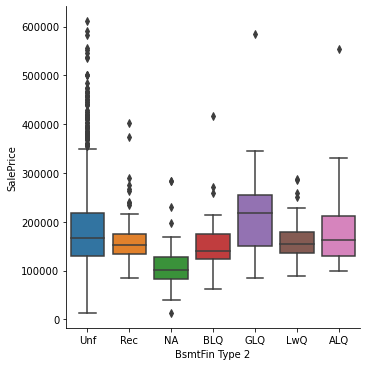

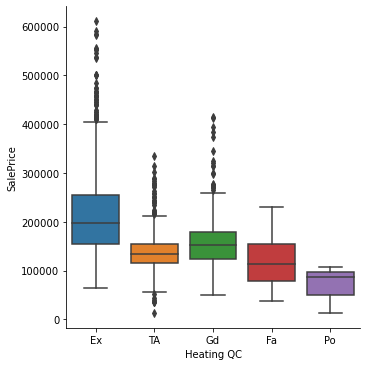

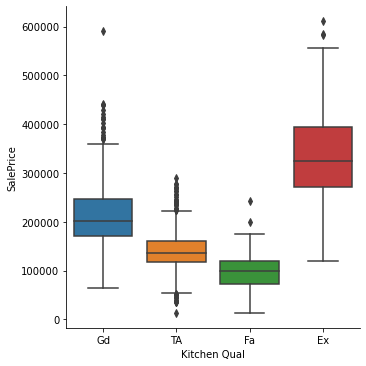

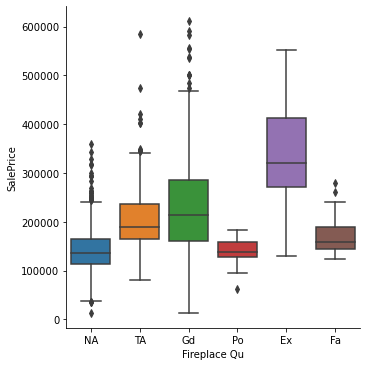

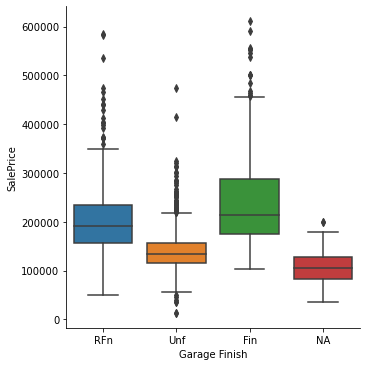

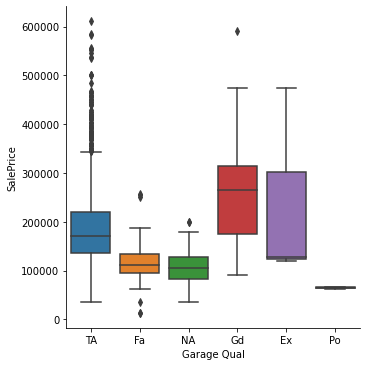

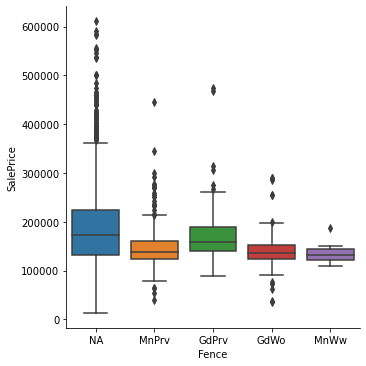

In [18]:
# Plot distributions of Ordinal variables with SalePrice to estimate if any relationships exist
for feature in feature_groups['Ordinal']:
    sns.catplot(x=feature, y='SalePrice', data=df, kind='box')

From the above, it does seem that SalePrice does vary with each remaining Ordinal feature.

For some features, there seems to be collinearity between SalePrice and the ranking within the Ordinal feature.

However, as we cannot assume equal distance between categories (e.g. assume Exterior Condition: Excellent is 5 times better than Exterior Condition: Poor), we can explore treating Ordinal features as Nominal features and binarize them.

In [19]:
# Ordinal features to retain for first feature set:
print(feature_groups['Ordinal'])

['Lot Shape', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Kitchen Qual', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Fence']


### Discrete Features

In [20]:
df[feature_groups['Discrete']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 109 to 10
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year Built      2051 non-null   int64  
 1   Year Remod/Add  2051 non-null   int64  
 2   Bsmt Full Bath  2049 non-null   float64
 3   Bsmt Half Bath  2049 non-null   float64
 4   Full Bath       2051 non-null   int64  
 5   Half Bath       2051 non-null   int64  
 6   Bedroom AbvGr   2051 non-null   int64  
 7   Kitchen AbvGr   2051 non-null   int64  
 8   TotRms AbvGrd   2051 non-null   int64  
 9   Fireplaces      2051 non-null   int64  
 10  Garage Yr Blt   1937 non-null   float64
 11  Garage Cars     2050 non-null   float64
 12  Mo Sold         2051 non-null   int64  
 13  Yr Sold         2051 non-null   int64  
dtypes: float64(4), int64(10)
memory usage: 320.4 KB


#### Null values

There are null values for 'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt' and 'Garage Cars'.

Based on the information in the data dictionary, null values for 'Bsmt Full Bath', 'Bsmt Half Bath' and 'Garage Cars' should be filled with 0.

Null values for 'Garage Yr Blt' can be filled with the mean value of 'Garage Yr Blt'.

In [21]:
# Fill null values for Discrete features
discrete_null_values = {'Bsmt Full Bath': 0,
                       'Bsmt Half Bath': 0,
                       'Garage Cars': 0,
                       'Garage Yr Blt': df['Garage Yr Blt'].mean()}
df.fillna(value=discrete_null_values, inplace=True)

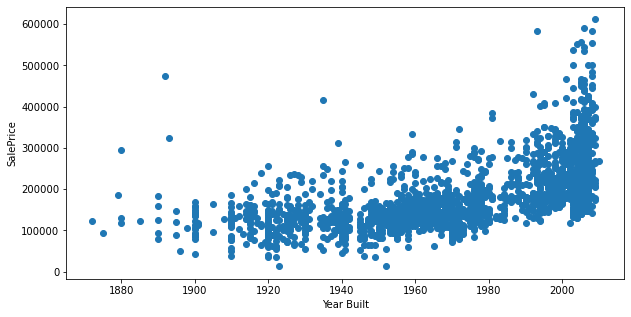

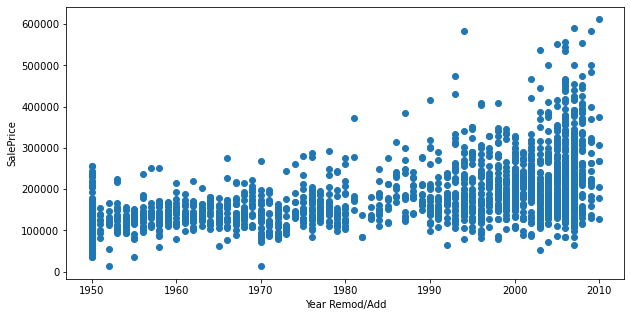

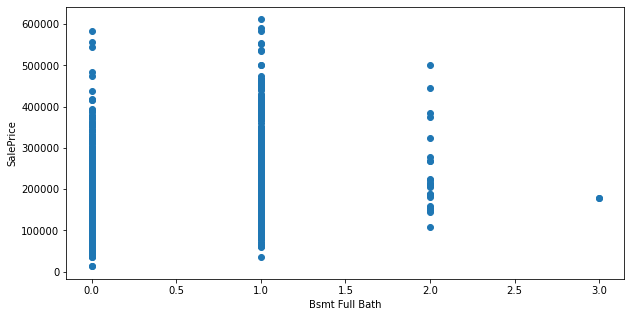

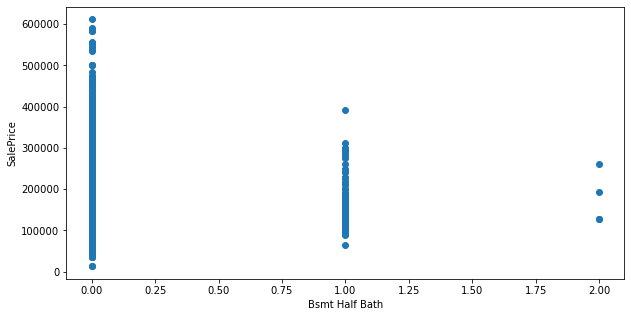

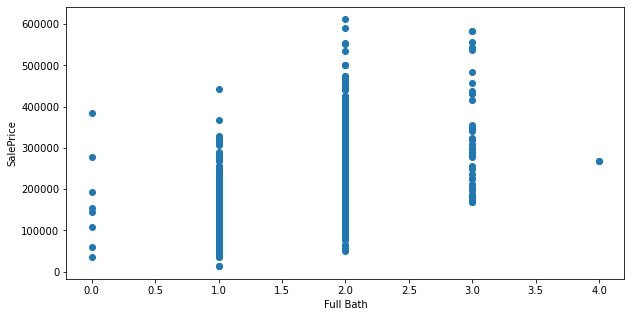

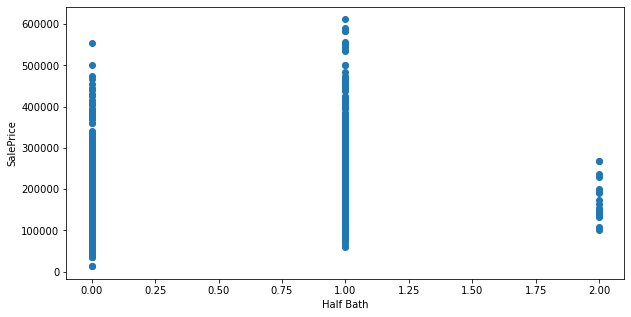

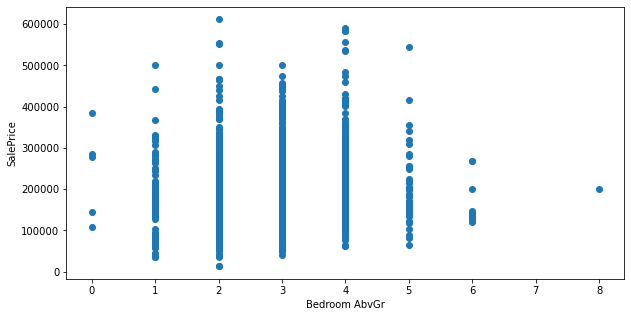

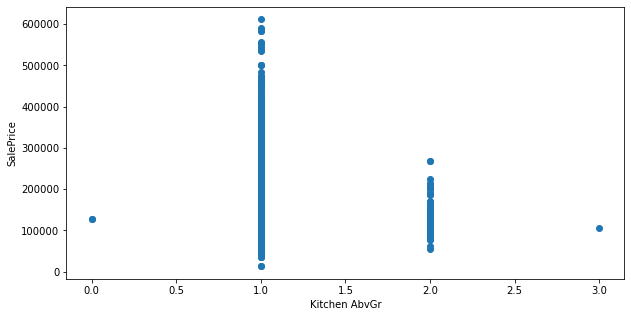

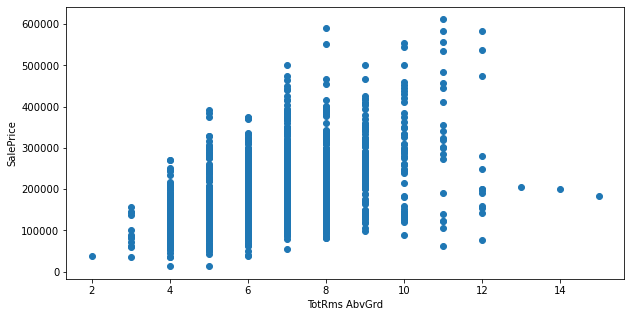

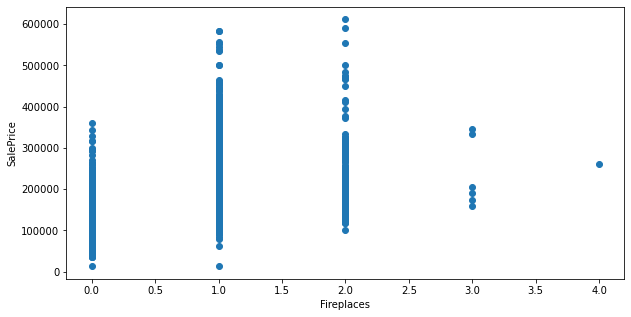

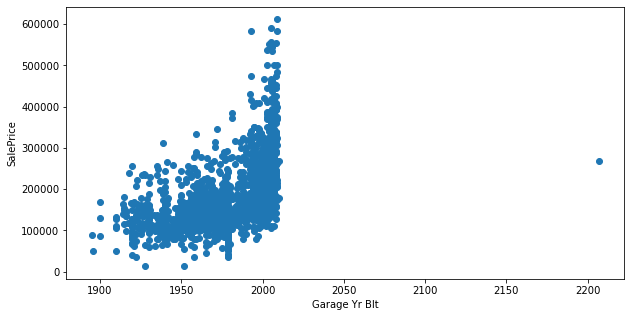

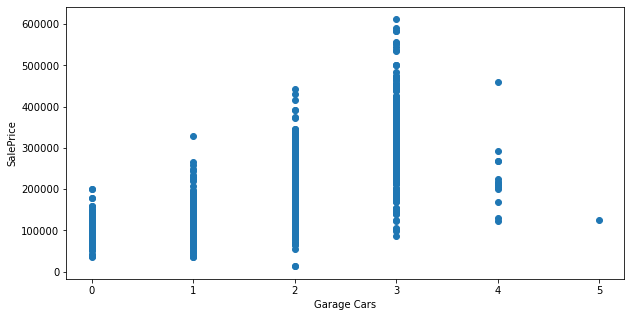

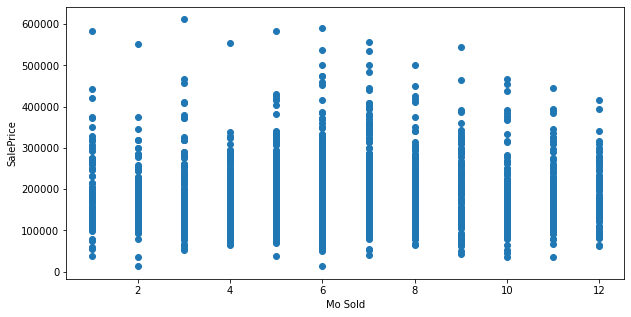

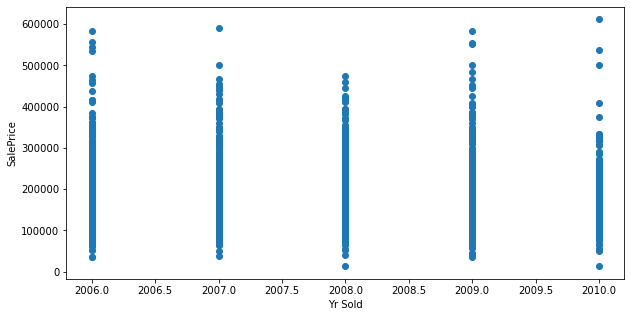

In [22]:
# Plot scatterplots with SalePrice to examine relationships and identify outliers
for feature in feature_groups['Discrete']:
    plt.figure(figsize=(10,5))
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.scatter(df[feature], df['SalePrice']);


#### Remove outliers

In [23]:
# Remove outliers
# Remove row with 'Bsmt Full Bath' = 3
df = df.drop(df[df['Bsmt Full Bath'] == 3].index)

In [24]:
# Remove rows with 'Bsmt Half Bath' = 2
df = df.drop(df[df['Bsmt Half Bath'] == 2].index)

In [25]:
# Remove row with 'Full Bath' = 4
df = df.drop(df[df['Full Bath'] == 4].index)

In [26]:
# Remove row with 'Bedroom AbvGr' = 8
df = df.drop(df[df['Bedroom AbvGr'] == 8].index)

In [27]:
# Remove row with 'Kitchen AbvGr' = 3
df = df.drop(df[df['Kitchen AbvGr'] == 3].index)

In [28]:
# Remove rows with 'TotRms AbvGrd' > 12
df = df.drop(df[df['TotRms AbvGrd'] > 12].index)

In [29]:
# Remove row with 'Fireplaces' = 4
df = df.drop(df[df['Fireplaces'] == 4].index)

In [30]:
# Remove row with 'Garage Yr Blt' > 2200
df = df.drop(df[df['Garage Yr Blt'] > 2200].index)

In [31]:
# Remove row with 'Garage Cars' = 5
df = df.drop(df[df['Garage Cars'] == 5].index)

#### Feature selection

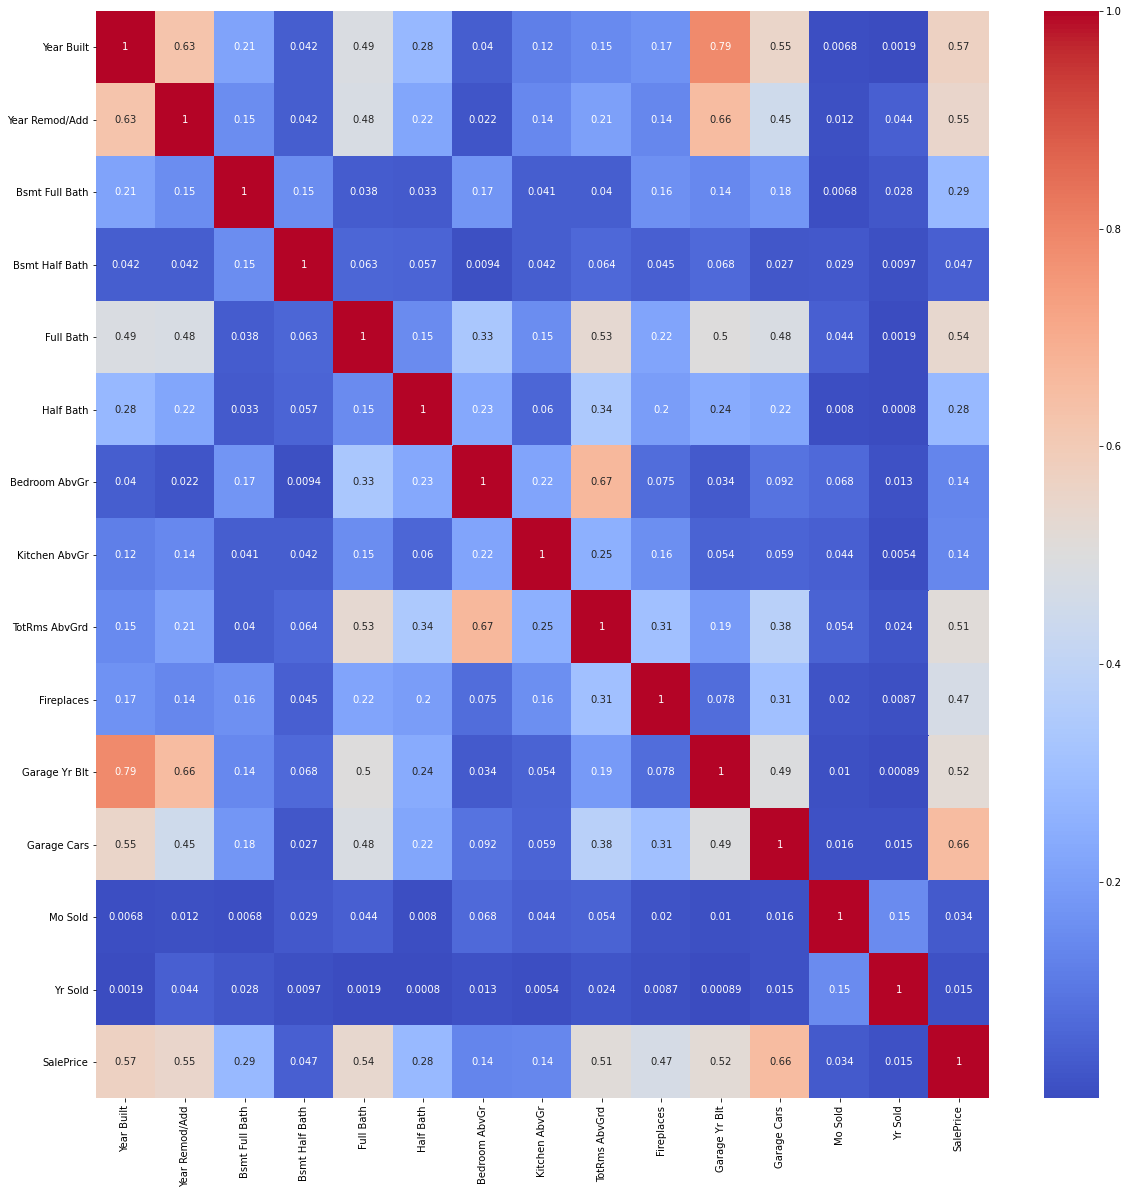

In [32]:
# Examine correlation between Discrete features with SalePrice

# Create dataframe of Discrete features
discrete_features = df[feature_groups['Discrete']].copy()
discrete_features['SalePrice'] = df['SalePrice'].copy()

# Plot heatmap of absolute correlation of Discrete variables
plt.figure(figsize=(20,20))
sns.heatmap(discrete_features.corr().abs(), cmap='coolwarm', annot=True);

Based on the heatmap, there are some Discrete features which have a high correlation with SalePrice which we should keep for our first feature set.

In [33]:
# Extract Discrete features with correlation to SalePrice above set threshold
threshold = 0.5
discrete_high_corr = []

# Iterate through correlation factors of SalePrice and extract feature with correlation greater than threshold
for feature, corr in dict(discrete_features.corr().abs()['SalePrice']).items():
    if feature != 'SalePrice':
        if corr > threshold:
            discrete_high_corr.append(feature)
        
print(discrete_high_corr)

['Year Built', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd', 'Garage Yr Blt', 'Garage Cars']


These features have collinearity between each other and thus violate the Multiple Linear Regression assumption of independence of predictors. We can regularize the model with Ridge or Lasso regression to reduce the effect of multicollinearity.

In [34]:
# Keep Discrete features selected above for feature engineering
feature_groups['Discrete'] = discrete_high_corr
print(feature_groups['Discrete'])

['Year Built', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd', 'Garage Yr Blt', 'Garage Cars']


### Continuous Features

In [35]:
df[feature_groups['Continuous']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2037 entries, 109 to 10
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Lot Frontage     1710 non-null   float64
 1   Lot Area         2037 non-null   int64  
 2   Mas Vnr Area     2016 non-null   float64
 3   BsmtFin SF 1     2036 non-null   float64
 4   BsmtFin SF 2     2036 non-null   float64
 5   Bsmt Unf SF      2036 non-null   float64
 6   Total Bsmt SF    2036 non-null   float64
 7   1st Flr SF       2037 non-null   int64  
 8   2nd Flr SF       2037 non-null   int64  
 9   Low Qual Fin SF  2037 non-null   int64  
 10  Gr Liv Area      2037 non-null   int64  
 11  Garage Area      2036 non-null   float64
 12  Wood Deck SF     2037 non-null   int64  
 13  Open Porch SF    2037 non-null   int64  
 14  Enclosed Porch   2037 non-null   int64  
 15  3Ssn Porch       2037 non-null   int64  
 16  Screen Porch     2037 non-null   int64  
 17  Pool Area     

#### Null values

There are null values for 'Lot Frontage', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Garage Area'.

Using information from the data dictionary, compare these features with other related features to determine if we should impute 0 or the mean value.

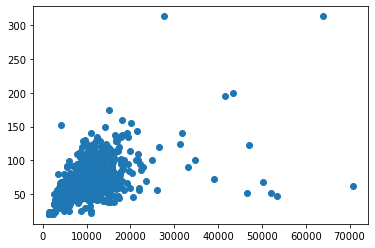

In [36]:
# Compare 'Lot Frontage' with 'Lot Area'
plt.scatter(df['Lot Area'], df['Lot Frontage'])

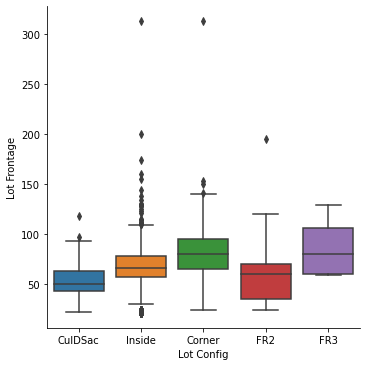

In [37]:
# Compare 'Lot Frontage' with 'Lot Config'
sns.catplot(x='Lot Config', y='Lot Frontage', data=df, kind='box')

Based on the above, there is no clear indication that 'Lot Frontage' should be set to 0. We can set the null values for 'Lot Frontage' to be equal to the mean

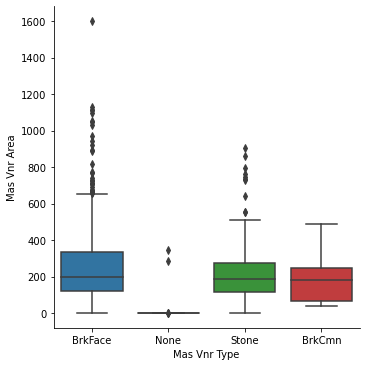

In [38]:
# Compare 'Mas Vnr Area' with 'Mas Type'
sns.catplot(x='Mas Vnr Type', y='Mas Vnr Area', data=df, kind='box')

In [39]:
df.loc[df['Mas Vnr Area'].isnull(), ['Mas Vnr Type']]

,Mas Vnr Type
Id,
2393,None
2383,None
539,None
518,None
2824,None
1800,None
1455,None
1120,None
1841,None


Based on the above, 'Mas Vnr Area' with null values correspond to 'None' for 'Mas Vnr Type'. We can fill null values of 'Mas Vnr Area' with 0.

In [40]:
# Compare 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF' with 'Bsmt Qual' and 'Bsmt Cond'
df.loc[df['BsmtFin SF 1'].isnull() |
       df['BsmtFin SF 2'].isnull() |
       df['Bsmt Unf SF'].isnull()  |
       df['Total Bsmt SF'].isnull(),
       ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Qual', 'Bsmt Cond']]

,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Qual,Bsmt Cond
Id,,,,,,
1342,NaN,NaN,NaN,NaN,NA,NA


There is 1 row with null values for 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF'. This house has no basement, as referenced from 'Bsmt Qual' and 'Bsmt Cond'. Null values can be filled with 0.

In [41]:
# Check 'Garage Area' with 'Garage Type'
df.loc[df['Garage Area'].isnull(), ['Garage Type']]

,Garage Type
Id,
2237,Detchd


The house with a null value for 'Garage Area' actually has a garage. We can use the mean 'Garage Area' to replace the null value.

In [42]:
continuous_null_values = {  'Lot Frontage': df['Lot Frontage'].mean(),
                            'Mas Vnr Area': 0,
                            'BsmtFin SF 1': 0,
                            'BsmtFin SF 2': 0,
                            'Bsmt Unf SF': 0,
                            'Total Bsmt SF':0,
                            'Garage Area': df['Garage Area'].mean()}
df.fillna(value=continuous_null_values, inplace=True)

#### Remove outliers

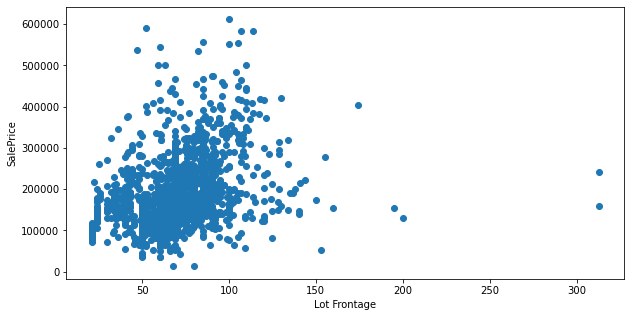

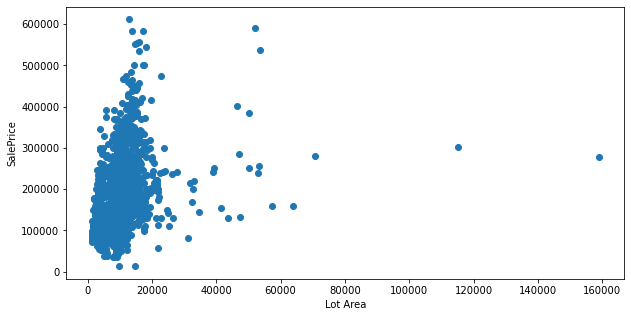

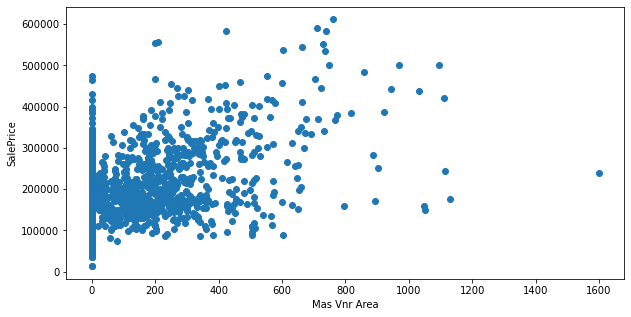

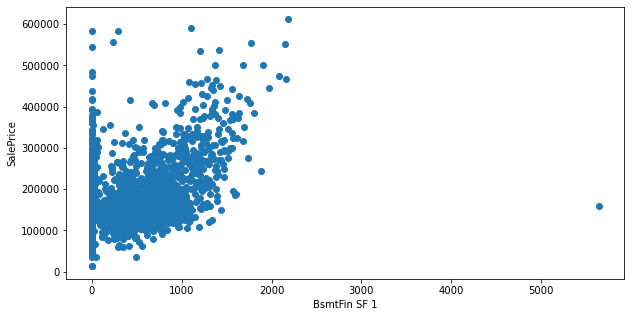

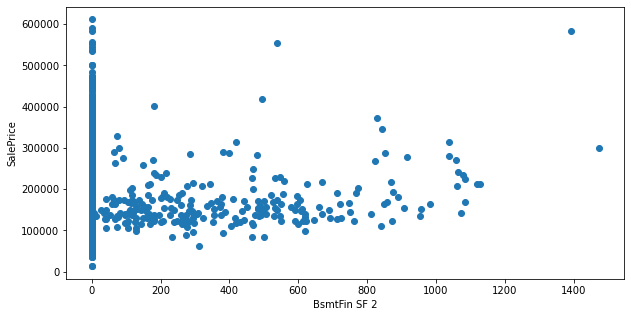

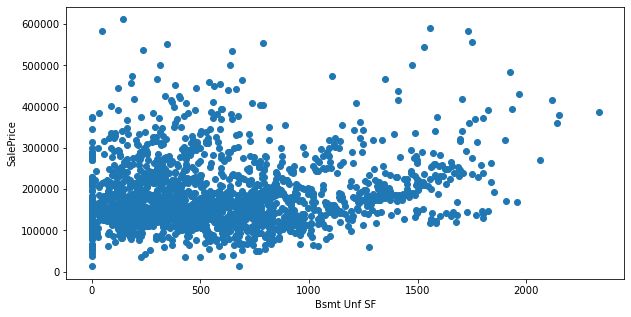

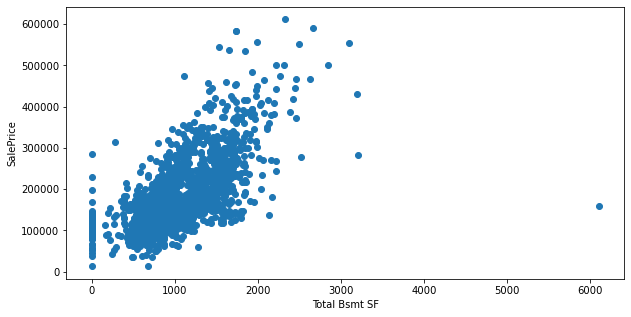

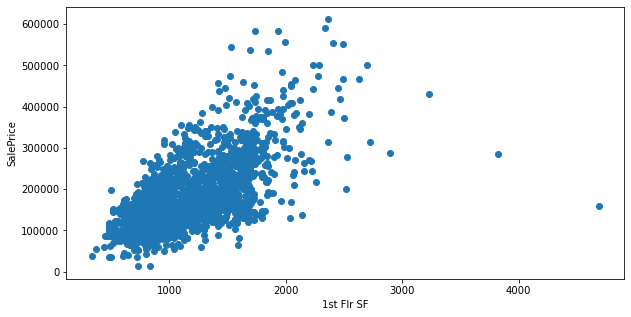

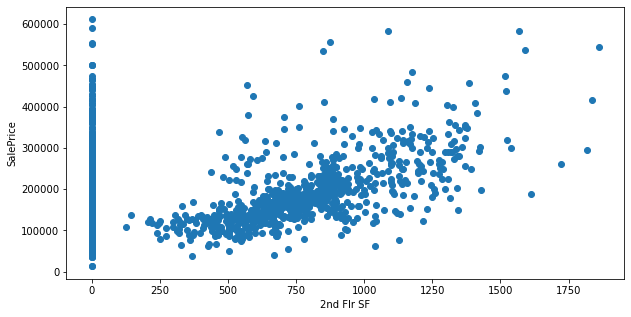

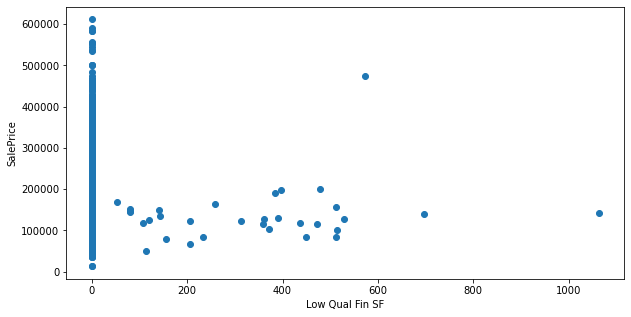

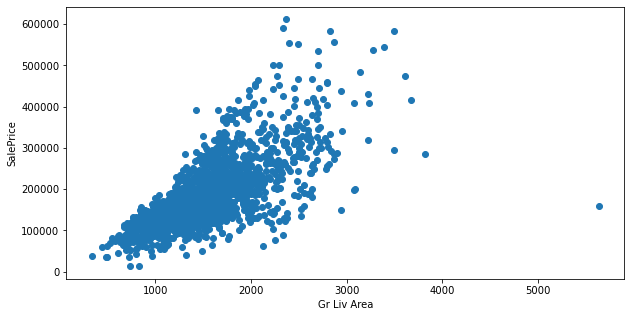

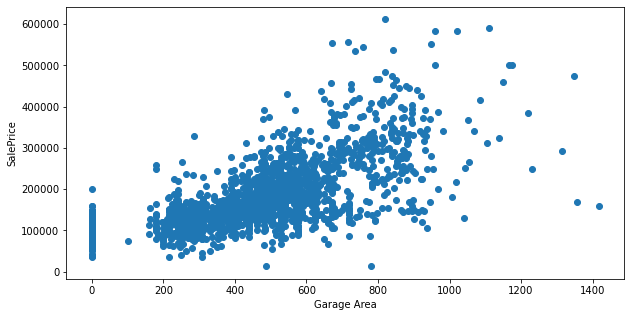

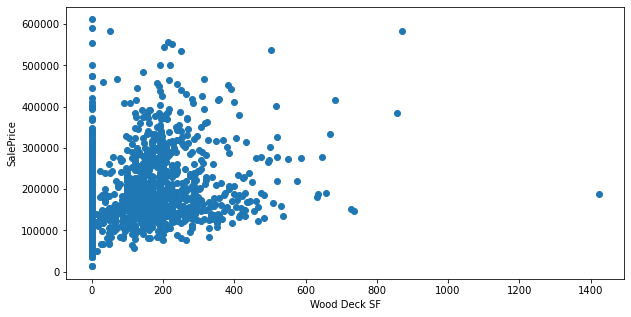

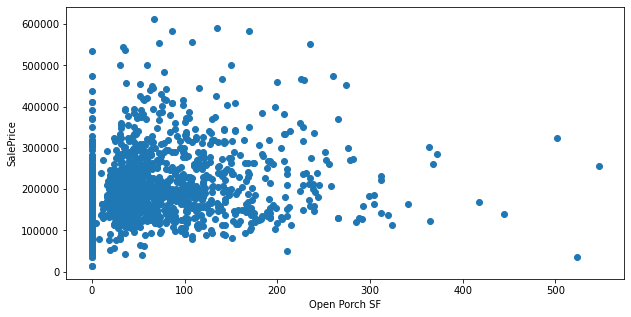

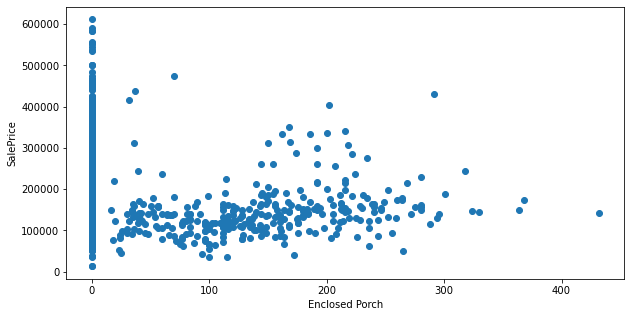

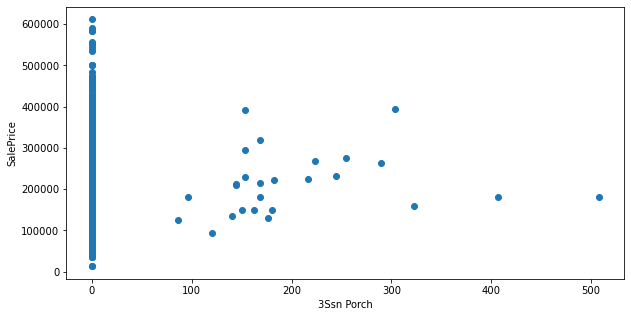

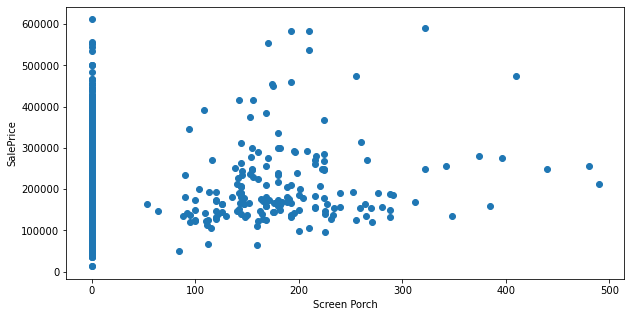

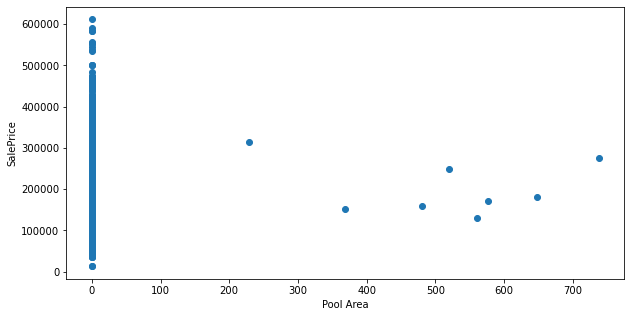

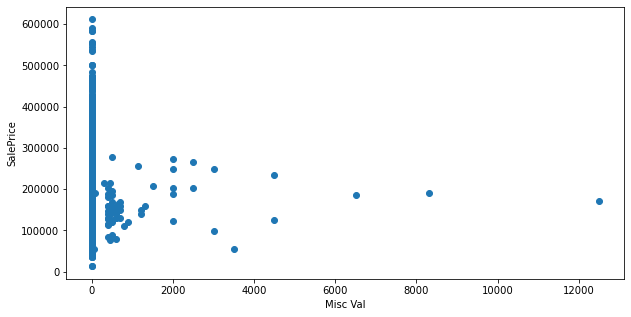

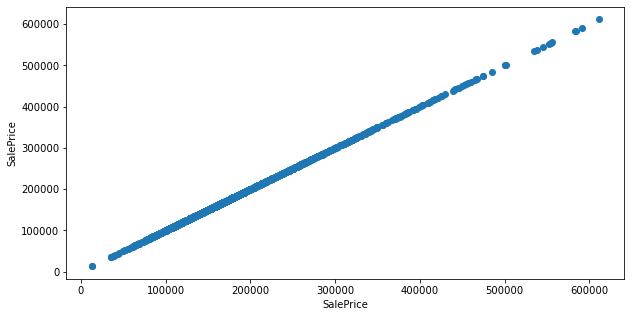

In [43]:
# Plot scatterplots with SalePrice to examine relationships and identify outliers
for feature in feature_groups['Continuous']:
    plt.figure(figsize=(10,5))
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.scatter(df[feature], df['SalePrice']);

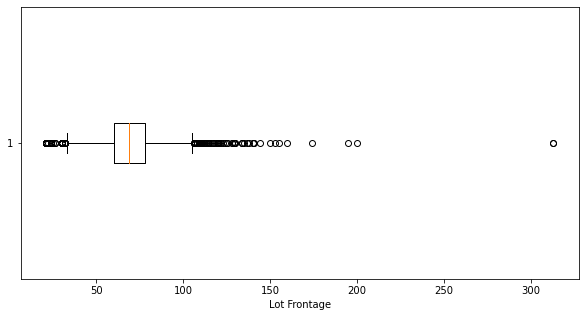

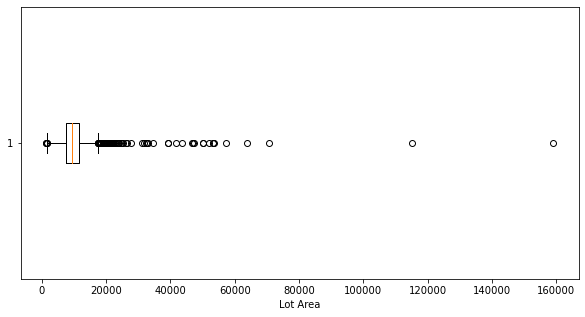

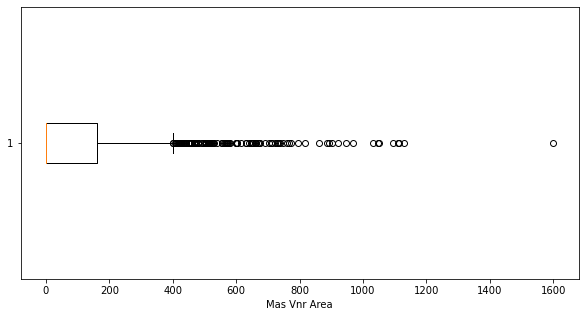

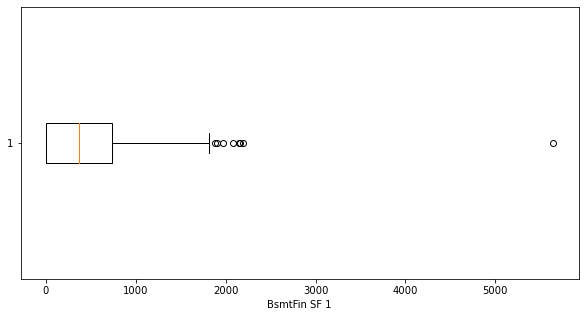

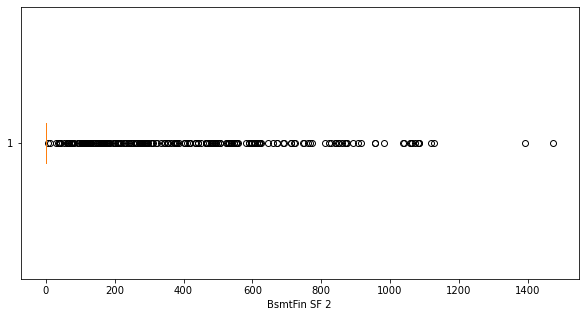

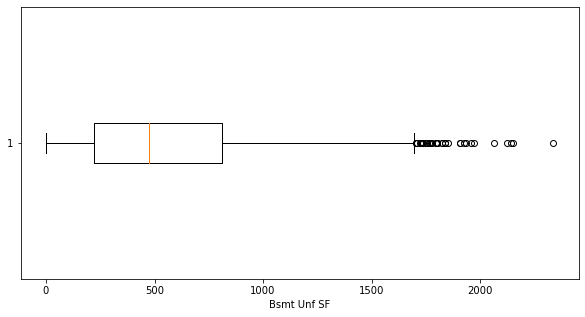

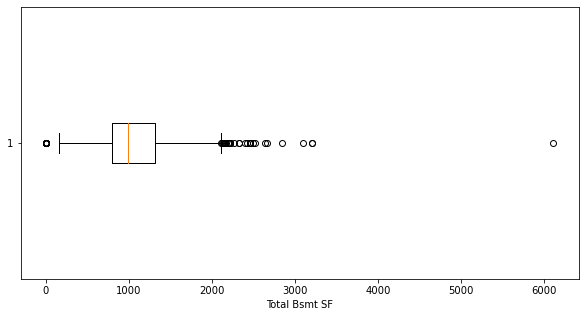

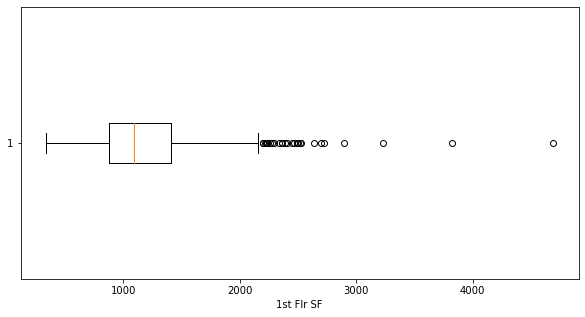

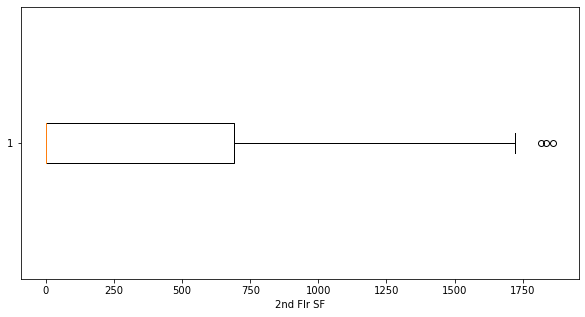

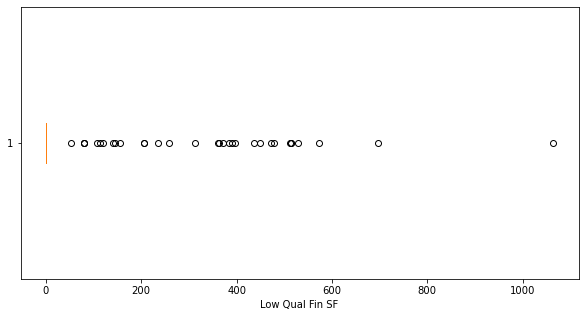

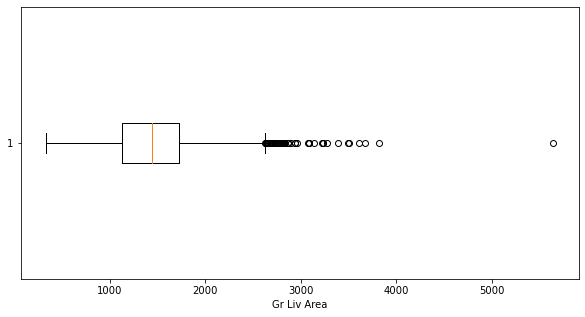

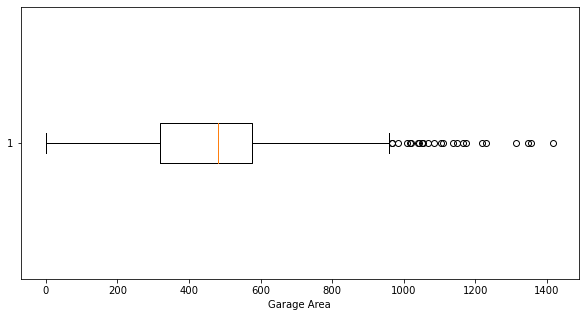

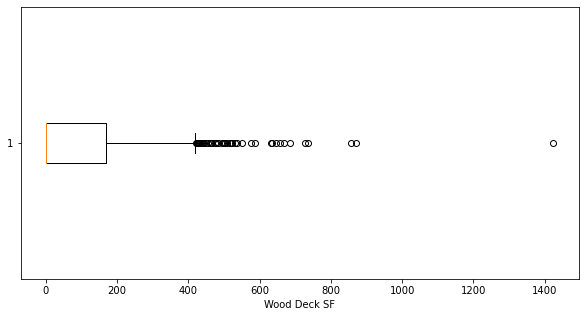

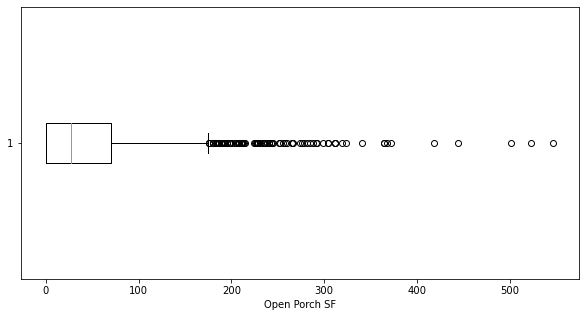

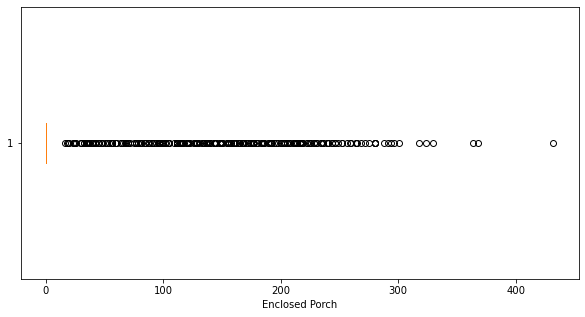

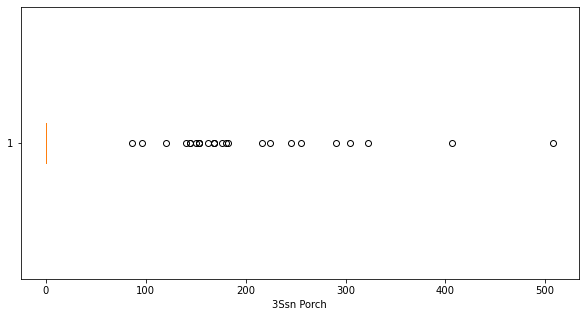

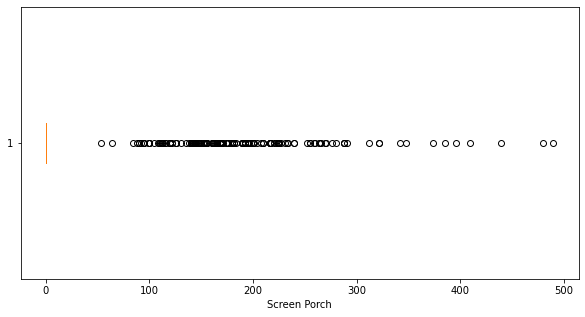

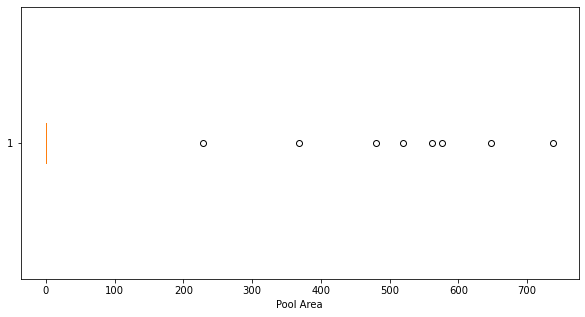

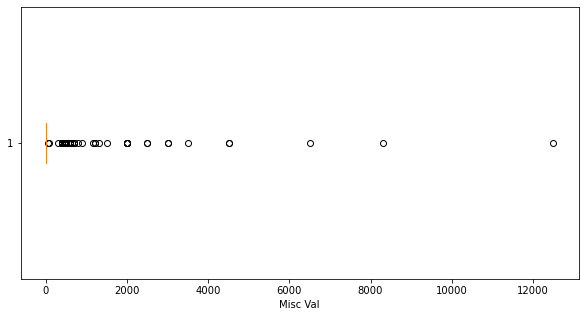

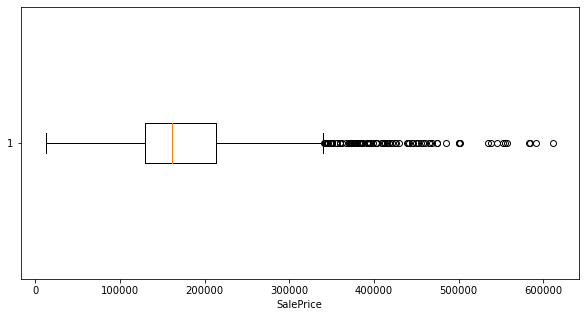

In [44]:
# Plot boxplots to examine distributions of individual Continuous features
for feature in feature_groups['Continuous']:
    plt.figure(figsize=(10,5))
    plt.xlabel(feature)
    plt.boxplot(df[feature], vert=False)

In [45]:
# Identify outliers with values > 3 std from the mean
continuous_outliers = {}

for feature in feature_groups['Continuous']:   
# Create a dictionary where key = feature and value = index of all the outliers
    continuous_outliers[feature] = df[abs(df[feature] - df[feature].mean()) > (3 * df[feature].std())].index

In [46]:
# Create a list of indexes for all outliers and remove duplicates
continuous_outliers_list = []
for feature, index in continuous_outliers.items():
    continuous_outliers_list.extend(index)
len(list(set(continuous_outliers_list)))

403

In [47]:
# There are 403 unique outliers, which is about 20% of the data.
# Adjust outliers to be > 4 std from the mean

continuous_outliers = {}

for feature in feature_groups['Continuous']:   
    continuous_outliers[feature] = df[abs(df[feature] - df[feature].mean()) > (4 * df[feature].std())].index
    
continuous_outliers_list = []
for feature, index in continuous_outliers.items():
    continuous_outliers_list.extend(index)
len(list(set(continuous_outliers_list)))

214

In [48]:
# Drop the outliers from the dataframe
df = df.drop(index=continuous_outliers_list)

#### Feature Selection

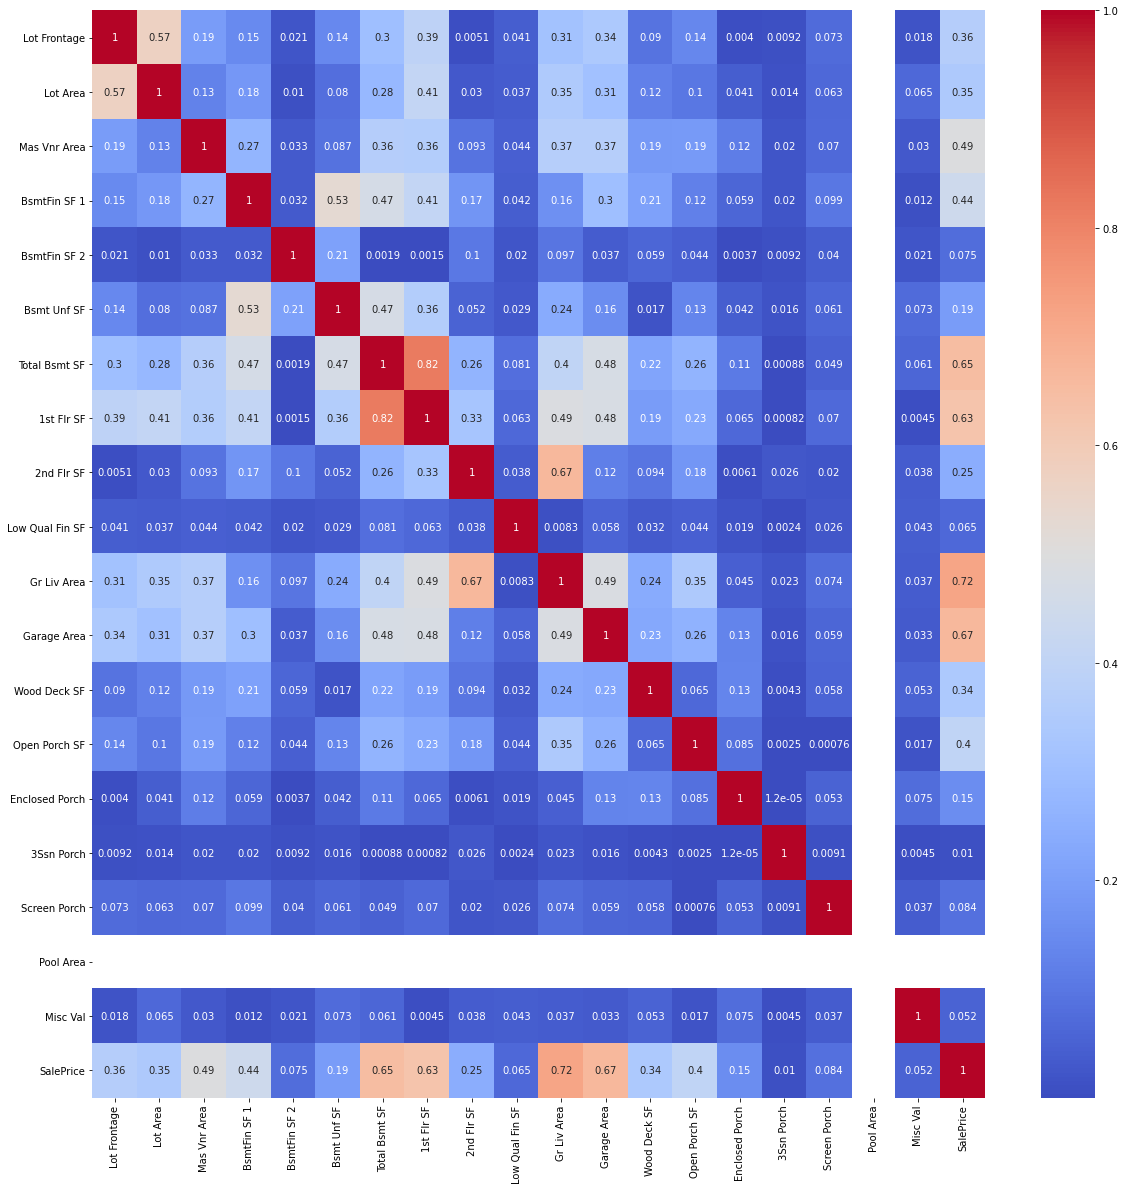

In [49]:
# Examine correlation between Continuous features with SalePrice

# Create dataframe of Continuous features
continuous_features = df[feature_groups['Continuous']].copy()
continuous_features['SalePrice'] = df['SalePrice'].copy()

# Plot heatmap of absolute correlation of discrete variables
plt.figure(figsize=(20,20))
sns.heatmap(continuous_features.corr().abs(), cmap='coolwarm', annot=True);

In [50]:
# Extract Continuous features with correlation to SalePrice above set threshold
threshold = 0.5
continuous_high_corr = []

# Iterate through correlation factors of SalePrice and extract feature with correlation greater than threshold
for feature, corr in dict(continuous_features.corr().abs()['SalePrice']).items():
    if feature != 'SalePrice':
        if corr > threshold:
            continuous_high_corr.append(feature)
        
print(continuous_high_corr)

['Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area']


Similar to the Discrete features, these Continuous features have collinearity between each other and thus violate the Multiple Linear Regression assumption of independence of predictors. We can regularize the model with Ridge or Lasso regression to reduce the effect of multicollinearity.

In [51]:
# Keep Continuous features selected above for first feature set
feature_groups['Continuous'] = continuous_high_corr
print(feature_groups['Continuous'])

['Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area']


## Pre-Processing

### Drop Unused Features

In [52]:
# Check remaining features
feature_groups

{'Nominal': ['MS SubClass',
  'MS Zoning',
  'Land Contour',
  'Lot Config',
  'Neighborhood',
  'Condition 1',
  'Bldg Type',
  'House Style',
  'Roof Style',
  'Exterior 1st',
  'Exterior 2nd',
  'Mas Vnr Type',
  'Foundation',
  'Garage Type',
  'Sale Type'],
 'Ordinal': ['Lot Shape',
  'Overall Qual',
  'Overall Cond',
  'Exter Qual',
  'Exter Cond',
  'Bsmt Qual',
  'Bsmt Cond',
  'Bsmt Exposure',
  'BsmtFin Type 1',
  'BsmtFin Type 2',
  'Heating QC',
  'Kitchen Qual',
  'Fireplace Qu',
  'Garage Finish',
  'Garage Qual',
  'Fence'],
 'Discrete': ['Year Built',
  'Year Remod/Add',
  'Full Bath',
  'TotRms AbvGrd',
  'Garage Yr Blt',
  'Garage Cars'],
 'Continuous': ['Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area']}

In [53]:
# Create list of remaining features
features = []
for feature_type, feature in feature_groups.items():
    features.extend(feature)

In [54]:
# Drop all columns in train dataset not in selected features
columns_to_drop = list(set(df.columns) - set(features))
columns_to_drop.remove('SalePrice')
df.drop(columns = columns_to_drop, inplace = True)

In [55]:
# Read in Kaggle test data
test = pd.read_csv('datasets/test.csv', index_col='Id')

In [56]:
# Drop same columns for Kaggle test data
test.drop(columns = columns_to_drop, inplace = True)

### Clean Kaggle Test Data

In [57]:
# Fill null values based on what was filled for train data
nominal_null_values = {'Alley': 'NA',
                       'Mas Vnr Type': 'None',
                       'Garage Type': 'NA',
                       'Misc Feature': 'NA'}
test.fillna(value=nominal_null_values, inplace=True)

ordinal_null_values = {'Bsmt Qual': 'NA',
                       'Bsmt Cond': 'NA',
                       'Bsmt Exposure': 'NA',
                       'BsmtFin Type 1': 'NA',
                       'BsmtFin Type 2': 'NA',
                       'Fireplace Qu': 'NA',
                       'Garage Finish': 'NA',
                       'Garage Qual': 'NA',
                       'Garage Cond': 'NA',
                       'Pool QC': 'NA',
                       'Fence': 'NA'}
test.fillna(value=ordinal_null_values, inplace=True)

discrete_null_values = {'Bsmt Full Bath': 0,
                       'Bsmt Half Bath': 0,
                       'Garage Cars': 0,
                       'Garage Yr Blt': df['Garage Yr Blt'].mean()}   # Fill 'Garage Yr Blt' null value with train data mean
test.fillna(value=discrete_null_values, inplace=True)

continuous_null_values = {  'Mas Vnr Area': 0,
                            'BsmtFin SF 1': 0,
                            'BsmtFin SF 2': 0,
                            'Bsmt Unf SF': 0,
                            'Total Bsmt SF':0,
                            'Garage Area': df['Garage Area'].mean()}  # Fill 'Garage Area' null value with train data mean
test.fillna(value=continuous_null_values, inplace=True)

In [58]:
# Check shape and null values
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 2658 to 1939
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MS SubClass     879 non-null    int64  
 1   MS Zoning       879 non-null    object 
 2   Lot Shape       879 non-null    object 
 3   Land Contour    879 non-null    object 
 4   Lot Config      879 non-null    object 
 5   Neighborhood    879 non-null    object 
 6   Condition 1     879 non-null    object 
 7   Bldg Type       879 non-null    object 
 8   House Style     879 non-null    object 
 9   Overall Qual    879 non-null    int64  
 10  Overall Cond    879 non-null    int64  
 11  Year Built      879 non-null    int64  
 12  Year Remod/Add  879 non-null    int64  
 13  Roof Style      879 non-null    object 
 14  Exterior 1st    879 non-null    object 
 15  Exterior 2nd    879 non-null    object 
 16  Mas Vnr Type    879 non-null    object 
 17  Exter Qual      879 non-null   

### Create Sub Train and Test Sets

In [59]:
# Assign SalePrice to y
y = df[['SalePrice']]

# Assign all remaining features to X
X = df[features]

In [60]:
# Split train.csv data into sub train/test sets
# This will be used for model refinement before testing against Kaggle test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Denote Kaggle train and test data as train_X and test_X
# The submission for Kaggle will train on the entire train.csv database and test on the test.csv file
train_X = df[features]
test_X = test[features]

### Scale Numeric Features

In [62]:
# Create list of numeric (Discrete and Continuous) features
numeric_features = feature_groups['Discrete'].copy()
numeric_features.extend(feature_groups['Continuous'])
numeric_features

['Year Built',
 'Year Remod/Add',
 'Full Bath',
 'TotRms AbvGrd',
 'Garage Yr Blt',
 'Garage Cars',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area',
 'Garage Area']

In [63]:
# Scale X_train and X_test
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train[numeric_features]), columns=X_train[numeric_features].columns)
X_test_scaled = pd.DataFrame(ss.transform(X_test[numeric_features]), columns=X_test[numeric_features].columns)

In [64]:
# Scale train_X and test_X (Kaggle submission data)
ss = StandardScaler()
train_X_scaled = pd.DataFrame(ss.fit_transform(train_X[numeric_features]), columns=train_X[numeric_features].columns)
test_X_scaled = pd.DataFrame(ss.transform(test_X[numeric_features]), columns=test_X[numeric_features].columns)

### Binarize Categorical Features

In [65]:
# Create list of categorical (Nominal and Ordinal) features
categorical_features = feature_groups['Nominal'].copy()
categorical_features.extend(feature_groups['Ordinal'])

In [66]:
categorical_features

['MS SubClass',
 'MS Zoning',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Exterior 1st',
 'Exterior 2nd',
 'Mas Vnr Type',
 'Foundation',
 'Garage Type',
 'Sale Type',
 'Lot Shape',
 'Overall Qual',
 'Overall Cond',
 'Exter Qual',
 'Exter Cond',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating QC',
 'Kitchen Qual',
 'Fireplace Qu',
 'Garage Finish',
 'Garage Qual',
 'Fence']

In [67]:
# Use get_dummies to binarize categorical features for X_train dataset
X_train_dummies = pd.get_dummies(X_train[categorical_features])
X_train_dummies.shape

(1458, 200)

In [68]:
# Use get_dummies to binarize categorical features for X_test dataset
X_test_dummies = pd.get_dummies(X_test[categorical_features])
X_test_dummies.shape

(365, 182)

In [69]:
# Use get_dummies to binarize categorical features for train_X dataset
train_X_dummies = pd.get_dummies(train_X[categorical_features])
train_X_dummies.shape

(1823, 203)

In [70]:
# Use get_dummies to binarize categorical features for test_X dataset
test_X_dummies = pd.get_dummies(test_X[categorical_features])
test_X_dummies.shape

(879, 200)

The categorical features in the different datasets contain different unique values. Thus the datasets will have different numbers of columns.

We can create columns that match the set union of all the unique categorical values, such that datasets will all have the same number of columns.

Empty columns can be filled with 0 since the value of the dummy variable would have been 0 anyway.

In [71]:
# Create a set with all the unique categorical dummy columns
dummy_total = set(train_X_dummies.columns) | set(test_X_dummies.columns)

In [72]:
# Create a function to add missing dummy columns to each X dataframe
def add_missing_dummy(dummy_total, X_dummies):
    missing_dummies = list(dummy_total - set(X_dummies.columns))
    for dummy in missing_dummies:
        X_dummies[dummy] = 0.0

In [73]:
# Add missing dummies to X data:
add_missing_dummy(dummy_total, X_train_dummies)
add_missing_dummy(dummy_total, X_test_dummies)
add_missing_dummy(dummy_total, train_X_dummies)
add_missing_dummy(dummy_total, test_X_dummies)

### Save Cleaned Data

In [74]:
# Ensure scaled X data indices are aligned with house 'Id'
X_train_scaled.set_index(X_train.index, inplace=True)
X_test_scaled.set_index(X_test.index, inplace=True)
train_X_scaled.set_index(train_X.index, inplace=True)
test_X_scaled.set_index(test_X.index, inplace=True)

In [75]:
# Combine scaled numeric data with categorical dummy columns
X_train_processed = pd.concat([X_train_scaled, X_train_dummies], axis = 1)
X_test_processed = pd.concat([X_test_scaled, X_test_dummies], axis = 1)
train_X_processed = pd.concat([train_X_scaled, train_X_dummies], axis = 1)
test_X_processed = pd.concat([test_X_scaled, test_X_dummies], axis = 1)

In [76]:
# Save cleaned train data to new csv file
df.to_csv('datasets/train_cleaned.csv', index=False)

In [77]:
# Save cleaned Kaggle test data to new csv file
test.to_csv('datasets/test_cleaned.csv', index=False)

In [87]:
# Save model tuning data: X_train, X_test, y_train, y_test
X_train_processed.to_csv('datasets/model_tuning/X_train_processed.csv')
X_test_processed.to_csv('datasets/model_tuning/X_test_processed.csv')
pd.DataFrame(y_train).to_csv('datasets/model_tuning/y_train.csv')
pd.DataFrame(y_test).to_csv('datasets/model_tuning/y_test.csv')

# Save Kaggle testing data: train_X, test_X, train_y
train_X_processed.to_csv('datasets/kaggle_submission/train_X_processed.csv')
test_X_processed.to_csv('datasets/kaggle_submission/test_X_processed.csv')
train_y = df['SalePrice']
pd.DataFrame(train_y).to_csv('datasets/kaggle_submission/train_y.csv')

02: Model Benchmarks will build a Linear Regression model based on all the features retained so far.